In [2]:
import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

jax.config.update("jax_enable_x64", True)  # crucial for Gaussian processes!
jax.config.update("jax_default_device", jax.devices()[0])

print('Jax version:          ', jax.__version__)  # 0.4.16
print('Distrax version:      ', dx.__version__)   # 0.1.5
print('Jax default backend:  ', jax.default_backend())  # verify that we're using the GPU

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import os
import sys
sys.path.append(os.path.expanduser('~/Documents/Repos/bayesianmodels/'))
from uicsmodels.gaussianprocesses.fullwp import FullLatentWishartModel
# from uicsmodels.bayesianmodels.gaussianprocesses import fullwp

Setting CUDA visible devices to [0]
Jax version:           0.4.23
Distrax version:       0.1.5
Jax default backend:   gpu


# About Wishart processes

Note: basic familiarity with Gaussian processes is assumed in the text below. However, copy-pastable code is provided further along!

## The technical stuff
Wishart processes (WPs) are used to model the dynamically changing covariances between $D$ variables, $\Sigma(x)$. At each input location $x$, $\Sigma(x) \in \mathbb{R}^{D\times D}$ and is positive definite. The WP is constructed from Gaussian process (GP) building blocks according to the following generative model:

\begin{align*}
    \theta &\sim \pi(\theta) &&\\
    f_{ij} &\sim \mathcal{GP}(0, \kappa_\theta) && i=1, \ldots, \nu,\quad j=1, \ldots, D\\
    L_{kl} & \sim \mathcal{N}(0, 1) && k=1,\ldots, D,\quad l=1, \ldots, k\\
    \mathbf{f}_i(x_n) & = (f_{i1}(x_n), \ldots, f_{iD}(x_n)) && i=1, \ldots, \nu\\
    \Sigma(x_n) &= \sum_{i=1}^{\nu} \mathbf{L} \mathbf{f}_i(x_n) \mathbf{f}_i(x_n)^\top \mathbf{L}^\top \sim \mathcal{W}\left(\nu, \mathbf{LL}^\top\right) && n=1, \ldots, N\\
    \mathbf{y}_n &\sim \mathcal{MVN}\left(\mathbf{\mu}, \Sigma(x_n)\right) && n=1, \ldots, N \enspace,
\end{align*} 

where $n=1, \ldots, N$, with $N$ the total number of observations, $\nu \geq D$ the degrees-of-freedom of the Wishart distribution, and lastly $\kappa_\theta$ the GP covariance function with parameters $\theta$.

Bayesian inference of the Wishart process comes down to approximating the posterior distribution $p(f, \theta, L \mid \mathbf{x}, \mathbf{Y})$, with $\mathbf{x}=(x_1, \ldots, x_N)$ and $\mathbf{Y}=(\mathbf{y}_1, \ldots, \mathbf{y}_N)^\top \in \mathbb{R}^{N\times D}$, and $\mathbf{y}_n \in \mathbb{R}^D$.

## The pragmatic stuff

We use a Wishart process to model the dynamics of covariance between 2 or more variables. The fact that the (co)variance of the variables in our systems is not constant, is known as heteroskedasticity. With a Wishart process we can learn the dynamic covariance from data, despite there being many free parameters compared to the number of observations.

# Dynamic covariance between mood variables

We'll explore a simple example based on data from questionnaires filled in by students at the KU Leuven (Bringmann et al., 2016; data kindly hosted by [Jonas Haslbeck](https://github.com/jmbh/EmotionTimeSeries)). These students reported on 6 mood variables (Angry,  Dysphoric, Sad, Anxious, Relaxed, and Happy) on a scale from 0--100. Here, we are not trying to model the students' scores on these different mood variables, but rather the covariance (c.q., correlation) between pairs of variables.

The code snippet below loads this data and shows the normalized time series for one subject (you can play around with the other subjects at your leisure).




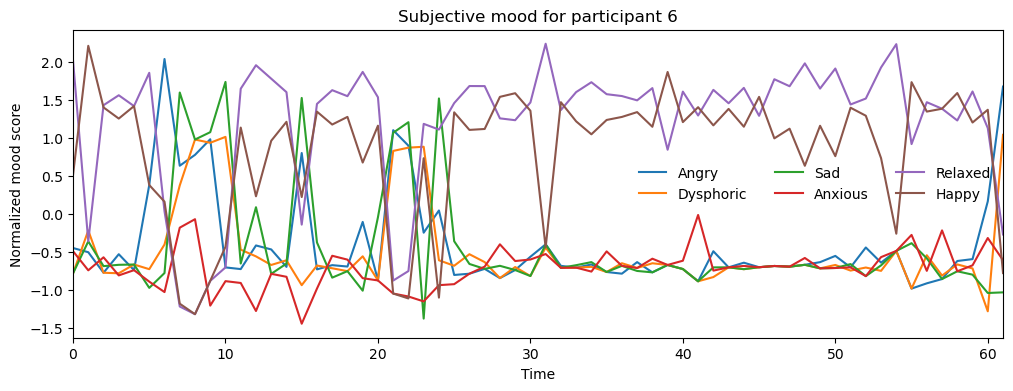

In [3]:
import numpy as np

names = ['Angry', 'Dysphoric', 'Sad', 'Anxious', 'Relaxed', 'Happy']

file = 'https://raw.githubusercontent.com/jmbh/EmotionTimeSeries/master/DataFromAuthors/Bringmann2016/Data95.csv'
data = np.genfromtxt(file, delimiter=';', skip_header=1)

Y_raw = data[:, [1, 3, 5, 7, 9, 11]]

# Remove records contains missing values, NaNs or 9999s.
Y_raw[Y_raw==9999] = jnp.nan
nan_ix = jnp.isnan(Y_raw).any(axis=1)
Y_raw = Y_raw[~nan_ix, :]

ids = data[~nan_ix, 0]
Y_all = ((Y_raw.T - jnp.mean(Y_raw.T, axis=0))/ jnp.std(Y_raw.T, axis=0)).T

subj_id = 6
Y = jnp.array(Y_all[ids==subj_id, :])
n, d = Y.shape

plt.figure(figsize=(12, 4))
plt.plot(Y, label=names)
plt.xlim([0, n-1])
plt.xlabel('Time')
plt.ylabel('Normalized mood score')
plt.legend(ncols=3, frameon=False)
plt.title(f'Subjective mood for participant {subj_id}');

## Setup of the Wishart process

With these time series available as our observations $\mathbf{Y}$, we can now estimate the Wishart process using the code below. It contains a couple of import concepts.

1. First, we select which covariance function `cov_fn` to use. Here we use the standard radial basis function (RBF) kernel, which is also known as the squared-exponential. It implies that covariances change smoothly.
2. Second, we must specify the priors over all parameters apart from the Gaussian processes $f$ (as there we already know they are GPs). The parameters consists of $\mathbf{L}$ in our likelihood, for wich we use a standard Gaussian distribution for each of the elements in its lower triangular matrix (see the generative model above). The other priors are assigned to the different parameters of the covariance function. In the case of the RBF, there are two; the lengthscale $\ell$, for which we say $p(\ell) = \mathcal{N}(\ell ; 0, 1)$, and the variance $\tau$. However, the Wishart process construction requires that $\kappa(x,x)=\tau=1$, so we do not assign a prior to $\tau$ and instead have it default to 1.0 (this is performed under the hood by the `FullLatentWishartModel`).


In [4]:
x = jnp.linspace(0, 1, n)
m = int(d*(d+1)/2)

cov_fn = jk.RBF()

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())),
              likelihood=dict(L_vec=dx.Normal(loc=jnp.zeros((m, )),
                                              scale=jnp.ones((m, )))))

wp = FullLatentWishartModel(x, Y, cov_fn=cov_fn, priors=priors)

## Inference

We are now ready to perform inference, which we do using _Sequential Monte Carlo_ (SMC). SMC is a highly effective approximate inference approach for models with many local minima, as SMC is great are exploring the full width of the distribution. Much of the heavy lifting of SMC can be done in parallel, which enables exploiting GPU hardware, as we do here. Still, inference of the Wishart process is a computationally demanding process! Using the V100 GPU on Google Colab, this takes about 4-5 minutes, and up to 15 on the AI cluster.

In [5]:
%%time

seed = 42
key = jrnd.PRNGKey(seed)

key, subkey = jrnd.split(key)
particles, _, lml = wp.inference(subkey,
                                 mode='gibbs-in-smc',
                                 sampling_parameters=dict(num_particles=1000,
                                                          num_mcmc_steps=1000))

## Visualize output

Training is done! We now visualize the result, but we scale the covariance matrices to correlation matrices for easier interpretation. In addition, we perform some simple statistical tests:

- By checking whether the $\rho_{ij}(x)=0$ falls in the 95% highest density interval, we determine whether `no correlation' was likely, given the data.
- By checking whether the $\rho_{ij}(x)=c \neq 0$ falls in the 95% highest density interval, we determine whether `static correlation' (S) was likely, given the data.
- If neither tests are successful, _dynamic_ correlaton (D) remains.


S: static correlation
D: dynamic correlation


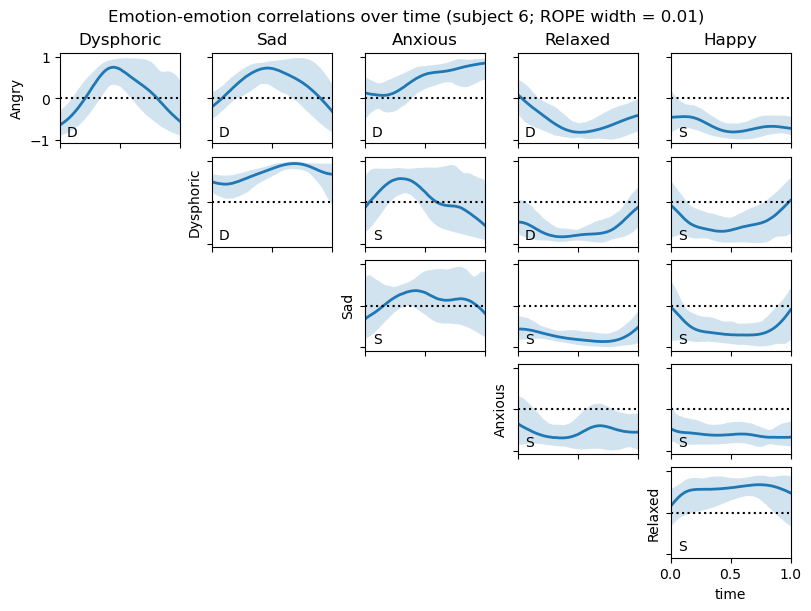

In [ ]:
from uicsmodels.gaussianprocesses.plotutil import plot_wishart_dist
from uicsmodels.gaussianprocesses.wputil import cov2corr, construct_wishart_Lvec

def construct_wishart_samples(samples):
    F_samples = samples['f']
    L_vec_samples = samples['likelihood']['L_vec']
    return jax.vmap(construct_wishart_Lvec, in_axes=(0, 0))(F_samples,
                                                            L_vec_samples)

#
samples = wp.get_monte_carlo_samples()
Sigma_samples = construct_wishart_samples(samples)

corr_samples = jax.vmap(jax.vmap(cov2corr, in_axes=0), in_axes=0)(Sigma_samples)
axes = plot_wishart_dist(x, corr_samples, include_diagonal=False)

for i in range(len(names) - 1):
    axes[0, i].set_title(names[i+1])
    axes[i, i].set_ylabel(names[i])
    for j in range(i, len(names)-1):
        axes[i, j].axhline(y=0, color='k', ls=':')
        axes[i, j].set_xlim([x[0], x[-1]])

ROPE = 0.005

for i in range(0, d):
    for j in range(i+1, d):
        corr_dist = corr_samples[:, :, i, j]
        lb, ub = jnp.percentile(corr_dist, q=jnp.array([2.5, 97.5]), axis=0)
        if jnp.min(ub) < jnp.max(lb) - ROPE:
            axes[i, j-1].text(0.1, -0.9, 'D', ha='center')
        elif jnp.min(ub) < 0 - ROPE or jnp.max(lb) > 0 + ROPE:
            axes[i, j-1].text(0.1, -0.9, 'S', ha='center')

axes[-1, -1].set_xlabel('time')
plt.suptitle(f'Emotion-emotion correlations over time (subject {subj_id}; ROPE width = {2*ROPE})');
print('S: static correlation')
print('D: dynamic correlation')

---
# Dynamic correlations between stock indices

Wishart processes trace their roots back to the analysis of financial time series. Here we'll explore such an example as well. We'll use the code to download data provided by [Sarem Seitz](https://github.com/SaremS/sample_notebooks/blob/master/Multivariate%20GARCH.ipynb) to download the closing prices of two stock indices, DAX and S&P500.

Download timeseries


[*********************100%%**********************]  2 of 2 completed


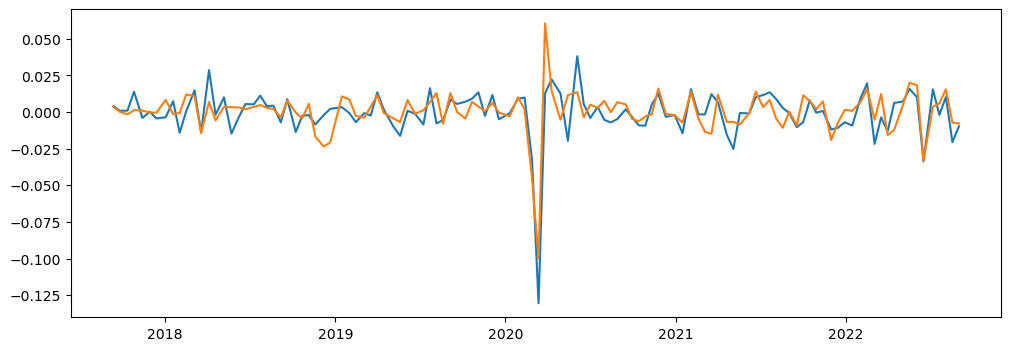

In [4]:
from uicsmodels.gaussianprocesses.wputil import tril2vec, construct_wishart_Lvec
from uicsmodels.gaussianprocesses.plotutil import plot_wishart_dist

import numpy as np
import yfinance as yf

print('Download timeseries')
data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

Y = jnp.asarray(returns.iloc[0:-1:10, :])
time = returns.index[0:-1:10]

plt.figure(figsize=(12, 4))
plt.plot(time, Y[:, 0]);
plt.plot(time, Y[:, 1]);

Then we set up the Wishart process and run inference again. We have more observations, but fewer variables and the process takes about 1.5 minute.

In [5]:
%%time
n = len(time)
x = jnp.linspace(0, 1, n)

d = Y.shape[1]
m = int(d*(d+1)/2)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                                scale=1.),
                                                        tfb.Exp())),
                likelihood=dict(L_vec=dx.Normal(loc=jnp.zeros((m, )),
                                                scale=jnp.ones((m, )))))

cov_fn = jk.RBF()

wp = FullLatentWishartModel(x, Y, cov_fn=cov_fn, priors=priors)

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)
particles, _, lml = wp.inference(subkey,
                                mode='gibbs-in-smc',
                                sampling_parameters=dict(num_particles=1000,
                                                        num_mcmc_steps=500))

CPU times: user 19min 56s, sys: 975 ms, total: 19min 57s
Wall time: 19min 55s


And we visualize the results:

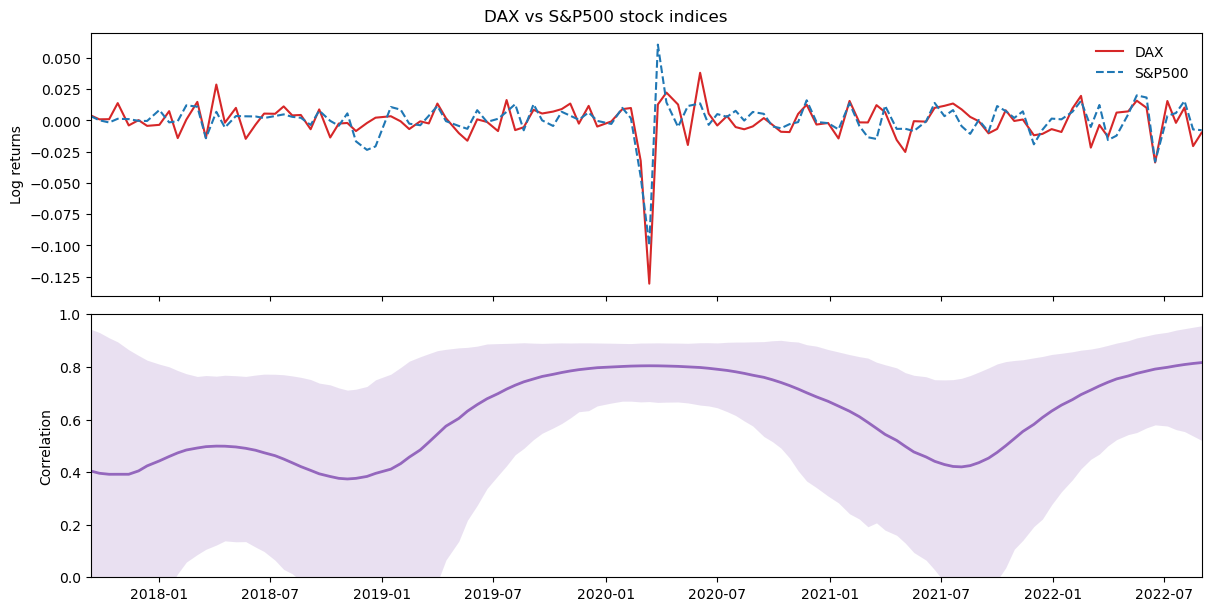

In [6]:
from uicsmodels.gaussianprocesses.plotutil import plot_dist
from uicsmodels.gaussianprocesses.wputil import cov2corr

def construct_wishart_samples(samples):
    F_samples = samples['f']
    L_vec_samples = samples['likelihood']['L_vec']
    return jax.vmap(construct_wishart_Lvec, in_axes=(0, 0))(F_samples,
                                                            L_vec_samples)

#
samples = wp.get_monte_carlo_samples()
Sigma_samples = construct_wishart_samples(samples)

corr_samples = jax.vmap(jax.vmap(cov2corr, in_axes=0), in_axes=0)(Sigma_samples)

_, axes = plt.subplots(nrows=2, ncols=1, sharex=True, constrained_layout=True, figsize=(12, 6))
axes[0].plot(time, Y[:,0], label='DAX', color='tab:red')
axes[0].plot(time, Y[:,1], label='S&P500', color='tab:blue', ls='--')
axes[0].legend(frameon=False)
axes[0].set_ylabel('Log returns')
plot_dist(axes[1], time, corr_samples[:, :, 0, 1], color='tab:purple')
axes[1].set_ylabel('Correlation')
axes[1].set_ylim([0., 1.0])
for ax in axes:
    ax.set_xlim([time[0], time[-1]])
plt.suptitle('DAX vs S&P500 stock indices');

The visualization shows that the correlation between the indices varies between approximately 0.1 all the way up to 0.8. The _uncertainty_ on this correlation is also variable, with the most certainty corresponding to stock market crash that followed the COVID-19 pandemic.